In [ ]:
# ================================================================
# CONFIGURATION SECTION
# ================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# -----------------------
# REPRODUCIBILITY
# -----------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

def worker_init(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

# -----------------------
# FILE PATH
# -----------------------
image_root_dir = "/kaggle/input/faceforensics-extracted-dataset-c23/FF++C32-Frames"
ORIGINAL_CSV = "/kaggle/input/faceforensics-extracted-dataset-c23/CSVs/Original.csv"
DEEPFAKES_CSV = "/kaggle/input/faceforensics-extracted-dataset-c23/CSVs/Deepfakes.csv"

# -----------------------
# SPLITS
# -----------------------
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
num_workers = 2

# ------------------------
# HYPERPARAMETERS
# ------------------------
LR = 1e-4
num_epochs = 200
best_val_loss = float('inf')
best_model_path = 'best_model_efficientnet_b7_amp.pth'
patience = 30
epochs_no_improve = 0

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# ================================================================
# BUILD DATAFRAME
# ================================================================
def build_combined_dataframe():
    df_original = pd.read_csv(ORIGINAL_CSV)
    df_deepfakes = pd.read_csv(DEEPFAKES_CSV)

    df = pd.concat([df_original, df_deepfakes], ignore_index=True)
    df['filepath'] = df.apply(lambda r: os.path.join(image_root_dir, r['label'], r["filename"]), axis=1    )
    df['label_id'] = df['label'].map({"Original": 0, "Deepfakes": 1})
    return df

# ================================================================
# DATASET
# ================================================================
class FFDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = read_image(row.filepath).float() / 255.0 

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(row["label_id"], dtype=torch.long)
        return img, label

# ================================================================
# TRANSFORMS 
# =================================================================
def get_transforms():
    return transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(5),
        transforms.ColorJitter(0.1, 0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
# ================================================================
# DATA LOADING
# ================================================================
df = build_combined_dataframe()
transform = get_transforms()
all_dataset = FFDataset(df, transform=transform)

total_len = len(all_dataset)
train_len = int(TRAIN_SPLIT * total_len)
val_len = int(VAL_SPLIT * total_len)
test_len = total_len - train_len - val_len 

train_set, val_set, test_set = random_split(all_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, worker_init_fn=worker_init, pin_memory=True)

print("Train distribution:", np.bincount([y for _, y in train_set]))
print("Val distribution:", np.bincount([y for _, y in val_set]))
print("Test distribution:", np.bincount([y for _, y in test_set]))

Train distribution: [3490 3510]
Val distribution: [764 736]
Test distribution: [746 754]


In [ ]:
# ================================================================
# PRETRAINED MODEL: EfficientNet-B7
# ================================================================
class EfficientNetB7Binary(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = models.efficientnet_b7(weights="IMAGENET1K_V1")
        in_features = self.backbone.classifier[1].in_features

        
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 1)
        )

    def forward(self, x):
        return self.backbone(x)

model = EfficientNetB7Binary().to(DEVICE)

# ================================================================
# OPTIMIZER, LOSS, SCALER (AMP)
# ================================================================
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()
# AMP GradScaler for mixed precision
scaler = torch.amp.GradScaler("cuda" if DEVICE == "cuda" else "cpu")

# ================================================================
# PROGRESSIVE LAYER-FREEZING SCHEDULE (same schedule you requested)
# ================================================================
def freeze_all_backbone(model):
    for p in model.backbone.features.parameters():
        p.requires_grad = False

def unfreeze_last_blocks(model, keep_frozen_until=6):
    
    for idx, block in enumerate(model.backbone.features):
        if idx >= keep_frozen_until:
            for p in block.parameters():
                p.requires_grad = True

def unfreeze_entire_backbone(model):
    for p in model.backbone.features.parameters():
        p.requires_grad = True

def apply_freezing_schedule(model, epoch):
    
    if epoch < 5:
        freeze_all_backbone(model)
    elif epoch < 15:
        freeze_all_backbone(model)
        unfreeze_last_blocks(model, keep_frozen_until=6)
    else:
        unfreeze_entire_backbone(model)


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 228MB/s] 


In [5]:
# ================================================================
# TRAINING LOOP (with AMP)
# ================================================================
for epoch in range(num_epochs):
    # Apply freezing/unfreezing at start of epoch
    apply_freezing_schedule(model, epoch)

    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in train_loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.float().to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision forward + loss
        with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
            outputs = model(images).view(-1)
            loss = criterion(outputs, labels)

        # Scales loss, calls backward, and unscales grads for optimizer.step()
        if DEVICE == "cuda":
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        train_loss += loss.item()

        with torch.no_grad():
            preds = torch.sigmoid(outputs).round()
        all_train_labels.extend(labels.detach().cpu().numpy())
        all_train_preds.extend(preds.detach().cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)

    # ---------------- VALIDATION (use autocast but no grad/scaler stepping) ----------------
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []
    all_val_probs = []

    with torch.no_grad():
        # optionally use autocast during validation to speed up fp16 ops
        for images, labels in val_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.float().to(DEVICE, non_blocking=True)

       
            with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
                outputs = model(images).view(-1)
                loss = criterion(outputs, labels)
                probs = torch.sigmoid(outputs)

            val_loss += loss.item()
            preds = (probs > 0.5).float()

            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())
            all_val_probs.extend(probs.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)

    # ---------------- CHECKPOINT ----------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save model weights (state_dict)
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated and saved at: {best_model_path}")
    else:
        epochs_no_improve += 1

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}"
    )

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# ================================================================
# LOAD BEST MODEL
# ================================================================
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.to(DEVICE)
print("Best model loaded.")

Best model updated and saved at: best_model_efficientnet_b7_amp.pth
Epoch 1/200 | Train Loss: 0.6957, Acc: 0.5096 | Val Loss: 0.6939, Acc: 0.5060
Best model updated and saved at: best_model_efficientnet_b7_amp.pth
Epoch 2/200 | Train Loss: 0.6933, Acc: 0.5209 | Val Loss: 0.6925, Acc: 0.5187
Best model updated and saved at: best_model_efficientnet_b7_amp.pth
Epoch 3/200 | Train Loss: 0.6920, Acc: 0.5217 | Val Loss: 0.6920, Acc: 0.5100
Best model updated and saved at: best_model_efficientnet_b7_amp.pth
Epoch 4/200 | Train Loss: 0.6871, Acc: 0.5414 | Val Loss: 0.6918, Acc: 0.5160
Best model updated and saved at: best_model_efficientnet_b7_amp.pth
Epoch 5/200 | Train Loss: 0.6847, Acc: 0.5513 | Val Loss: 0.6890, Acc: 0.5400
Best model updated and saved at: best_model_efficientnet_b7_amp.pth
Epoch 6/200 | Train Loss: 0.6421, Acc: 0.6187 | Val Loss: 0.5771, Acc: 0.6693
Best model updated and saved at: best_model_efficientnet_b7_amp.pth
Epoch 7/200 | Train Loss: 0.5271, Acc: 0.7171 | Val Loss


Test Results:
Accuracy:  0.9780
Precision: 0.9775
Recall:    0.9788
F1 Score:  0.9781
AUC-ROC:   0.9975

Classification Report:
               precision    recall  f1-score   support

           0     0.9785    0.9772    0.9779       746
           1     0.9775    0.9788    0.9781       754

    accuracy                         0.9780      1500
   macro avg     0.9780    0.9780    0.9780      1500
weighted avg     0.9780    0.9780    0.9780      1500

Confusion Matrix:
 [[729  17]
 [ 16 738]]


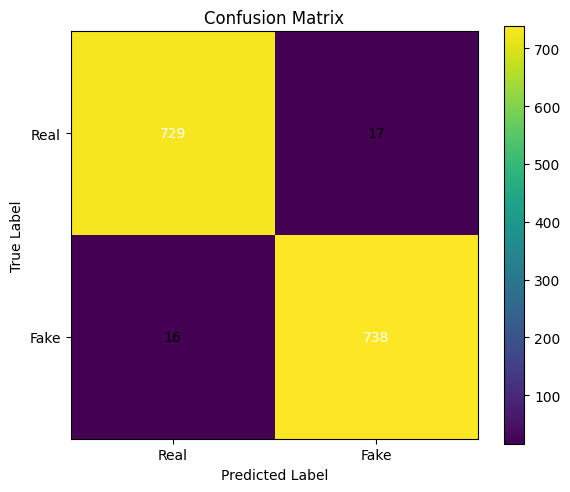

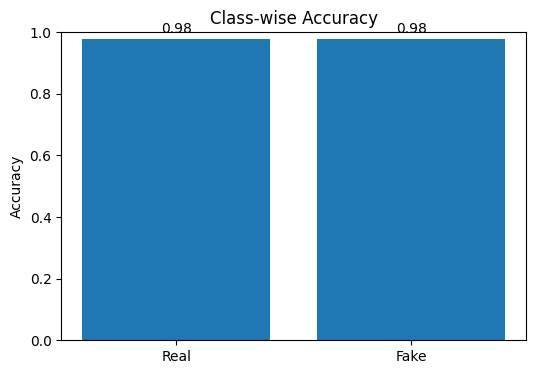

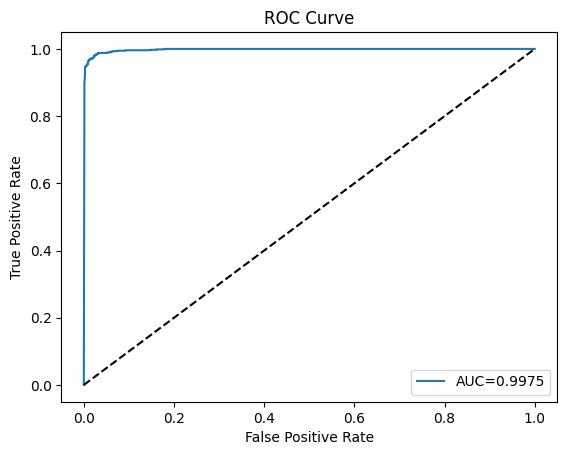

In [6]:
# ================================================================
# TEST EVALUATION (AMP-enabled inference)
# ================================================================
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
            outputs = model(images).view(-1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy
labels_np = np.array(all_labels)
preds_np = np.array(all_preds)
probs_np = np.array(all_probs)

# =================== METRICS ===================
precision = precision_score(labels_np, preds_np)
recall = recall_score(labels_np, preds_np)
f1 = f1_score(labels_np, preds_np)
accuracy = accuracy_score(labels_np, preds_np)
auroc = roc_auc_score(labels_np, probs_np)

print(f"\nTest Results:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auroc:.4f}")

print("\nClassification Report:\n", classification_report(labels_np, preds_np, digits=4))

# ================================================================
# CONFUSION MATRIX + PLOTS
# ================================================================
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_np, preds_np)
print("Confusion Matrix:\n", cm)

# -------- Confusion Matrix Heatmap --------
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

class_names = ["Real", "Fake"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Write numbers in each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()

# -------- Class-wise Accuracy --------
class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6, 4))
plt.bar(class_names, class_acc)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy")
for i, acc in enumerate(class_acc):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha="center")
plt.show()

# ================================================================
# ROC CURVE
# ================================================================
fpr, tpr, thresholds = roc_curve(labels_np, probs_np)
plt.plot(fpr, tpr, label=f'AUC={auroc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
